# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.solvers.naive_solver import NaiveSolver
from cloudmanufacturing.solvers.q_learning import QLearningSolver
from cloudmanufacturing.validation import objvalue, construct_delta
from cloudmanufacturing.mip_solver import mip_solve

# Loading data

In [2]:
problems = read_fatahi_dataset("../data/fatahi.xlsx")

  0%|          | 0/18 [00:00<?, ?it/s]

### Блок по экспериментам с данными

In [3]:
# Создание массива случайных подходящих gamma
num_problem = 2
problem = problems[num_problem]

n_cities = problems[num_problem]['n_cities']
n_suboperations = problem['n_suboperations']
n_operations = problem['n_operations']
time_cost = problem["time_cost"]



In [4]:
problems[2]

{'name': '5,10,10-3',
 'n_operations': 5,
 'n_suboperations': 10,
 'n_cities': 10,
 'n_services': 1,
 'operations': array([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0.]]),
 'dist': array([[   0.        , 1633.84292745,  611.70303957,   89.72076681,
         1130.56529382, 1238.97277599, 1035.89517346,  239.2701444 ,
          914.64484897, 2259.96549867],
        [1633.84292745,    0.        , 1739.44141395, 1718.00094704,
         2678.55942216, 1943.99364696, 2397.00976507, 1770.31697565,
         2532.42813768, 1388.23036974],
        [ 611.70303957, 1739.44141395,    0.        ,  649.74271027,
         1528.5603067 ,  632.84022906,  657.60732186,  427.72679529,
          980.23737024, 1942.79172047],
        [  89.72076681, 1718.00094704,  6

1. Случайные gamma на какой-то problem

In [5]:
n = 100000
gamma_array = set()

while len(gamma_array) < n:
    # random_array = np.random.randint(n_cities, size=(n_suboperations, n_operations))
    # Так нельзя делать! Можно выбирать только из допустимых. (См. пример в Q-lerning)

    # выбрали рандомно город
    time_inf = np.max(time_cost)
    random_array = np.zeros((n_suboperations, n_operations), dtype=int)
    for i in range(n_suboperations):
        valid_cities = np.where(time_cost[i] < time_inf)[0]
        random_array[i] = np.random.choice(valid_cities, n_operations, replace=True)

    gamma = np.zeros((n_suboperations, n_operations, n_cities))
    row_indices, col_indices = np.indices(random_array.shape)
    gamma[row_indices, col_indices, random_array] = 1 # построили gamma
    gamma *= np.broadcast_to(problem['operations'][:, :, np.newaxis], gamma.shape) # согласовали gamma с problem

    # Преобразование трехмерного массива в кортеж
    good_gamma = tuple(map(lambda x: tuple(map(tuple, x)), gamma))

    if len(gamma_array) % (n // 10) == 0:
        print('step', n // 10)
    gamma_array.add(good_gamma)


step 10000
step 10000
step 10000
step 10000
step 10000
step 10000
step 10000
step 10000
step 10000
step 10000


In [6]:
layers = [np.array(layer) for layer in list(gamma_array)]

# Применение функции objvalue к каждой gamma
results = np.array([objvalue(problem, gamma, construct_delta(problem, gamma)) for gamma in layers])

In [7]:
min(results)

17895.238977396722

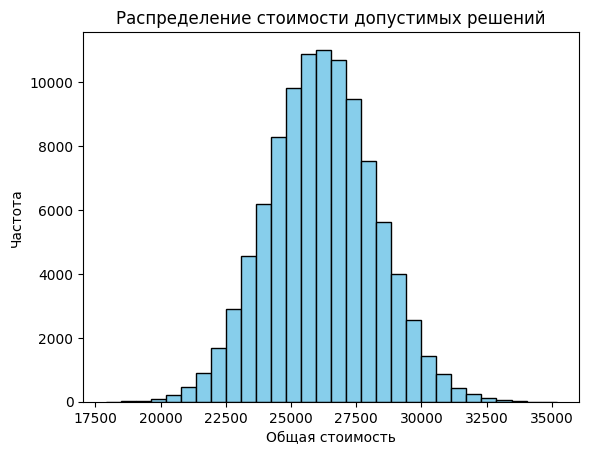

In [8]:
# Построение гистограммы
plt.hist(results, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Общая стоимость')
plt.ylabel('Частота')
plt.title('Распределение стоимости допустимых решений')
plt.show()

In [16]:
# 5% значений меньше этого числа
results_sorted = np.sort(results)
n_values = int(0.01 * len(results_sorted))
max_value = np.max(results_sorted[:n_values])
print(max_value)

21543.24069815589


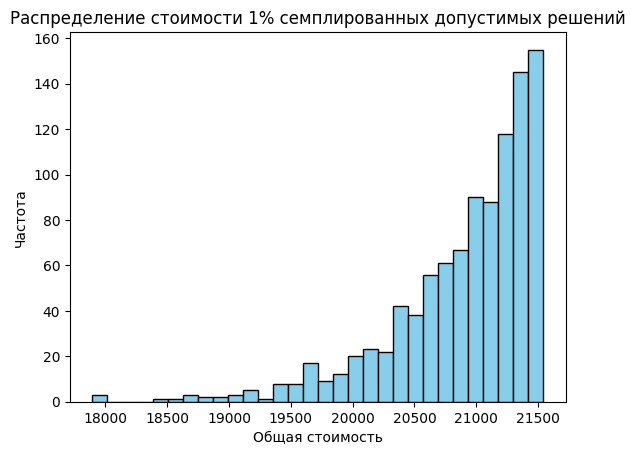

In [23]:
plt.hist(results_sorted[:n_values], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Общая стоимость')
plt.ylabel('Частота')
plt.title('Распределение стоимости 1% семплированных допустимых решений')
plt.show()

In [31]:
# меньше 20.000 столько значений
np.sum(results < 20000)

88

Вывод: хороших рандомных решений мало. (Очень плохих тоже мало). Из 100.000 решений без повторов лучшее имеет cost 126.000 при cost наивного алгоритма 12.500. Это значит, что очередной рандомный путь скорее всего будет хуже текущего наивного.

Теперь мы хотим посмотреть, как меняется cost, когда мы меняем наивную gamma и точную gamma на 1, 2, 3 шага. Гипотеза: cost будет сильно возрастать, субоптимальные значения cost находятся далеко друг от друга, что исследование у Q-learning не дотягивается до него.

Замечание: просто изменить город в одном месте будет неправильно, т.к. тогда меняется принятие решений у всех последующих субопераций. Надо зашивать ограничение в алгоритм.

2. Хочется посмотреть распределение, если мы берем не полностью случайную гамма, а часть из жадного или точного решения.
Для этого мы накладываем маску mask = [1, 1, 1 ...] ... [0, 0, 0 ...], gamma_mip * mask + gamma_rand * (~mask)

|3. Посмторим на 1 шаг от жадного решения. (Потом на 2 шага). Хочется ввети термин 1-устойчивости.

In [83]:
problems[2]

{'name': '5,10,10-3',
 'n_operations': 5,
 'n_suboperations': 10,
 'n_cities': 10,
 'n_services': 1,
 'operations': array([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0.]]),
 'dist': array([[   0.        , 1633.84292745,  611.70303957,   89.72076681,
         1130.56529382, 1238.97277599, 1035.89517346,  239.2701444 ,
          914.64484897, 2259.96549867],
        [1633.84292745,    0.        , 1739.44141395, 1718.00094704,
         2678.55942216, 1943.99364696, 2397.00976507, 1770.31697565,
         2532.42813768, 1388.23036974],
        [ 611.70303957, 1739.44141395,    0.        ,  649.74271027,
         1528.5603067 ,  632.84022906,  657.60732186,  427.72679529,
          980.23737024, 1942.79172047],
        [  89.72076681, 1718.00094704,  6

Идея реализации для 1-шага:
```
for (по каждой субоперации):
    while (пока не осталось доступных городов для этой операции):
        стоимость в текущем выбранном городе = 99 (макс)
        решить заново с текущими ограничениями
        записать cost в массив
```

### Q-learning

Эксперимент с 1-расстоянием

In [3]:
naive_solver = NaiveSolver(problems)

info_problem, gamma_naiv, delta = naive_solver.solve_problem(2)

In [7]:
num_problem = 2
one_dist_cost = []
naiv_info_problem = copy.deepcopy(info_problem)
sub_number = 0
for suboperation in naiv_info_problem['path']:
    for city in np.unique(naiv_info_problem['path'][suboperation]):
        city = int(city)
        new_problems = copy.copy(problems)
        new_problems[num_problem]['time_cost'][sub_number, city] = 99
        naive_solver = NaiveSolver(new_problems)
        info_problem, gamma, delta = naive_solver.solve_problem(num_problem)
        one_dist_cost.append(objvalue(problems[num_problem], gamma, delta))
    sub_number += 1


In [8]:
np.unique(np.array(one_dist_cost))

array([14849.0855136 , 16995.53328776, 17034.72061482, 18264.18124941])

# Solving problem

In [119]:
naive_solver = NaiveSolver(problems)

info_problem, gamma_naiv, delta = naive_solver.solve_problem(2)

operation_number 0 cost 3315.420480303362
operation_number 1 cost 2134.746993251602
operation_number 2 cost 3315.420480303362
operation_number 3 cost 2744.9966841570763
operation_number 4 cost 1011.1103070711365


In [138]:
delta, gamma_mip, status, value = mip_solve(problems[2])

In [139]:
np.sum(np.abs(gamma_mip - gamma_naiv)) / 2 # псевдорасстояние от наивной гаммы до оптимальной

27.0

In [140]:
objvalue(problems[num_problem], gamma_mip, delta)

10859.414889085907

In [38]:
#           сказать, что
# 1) Исследована архитектура актор-критика
# 2) Исправлены ошибки при запуске кода из коробки (показать какие)
# 3) Построить графики по Q-learning (для этого запоминать q функцию и дообучать ее до 2 000 000 эпох)
# 4) Интерпритировать результат
# 5) Привести сравнительную таблицу подходов на "их" данных для другой задачи без логистики
# 6) Привести сравнительную таблицу наших методов на наших данных

In [111]:
q_learning_solver = QLearningSolver(problems)

alpha = 0.8
rl_gamma = 2
epsilon = 0.6
epoch_number = 5000

info_problem, gamma, delta, cost_in_check_point = q_learning_solver.solve_problem(8, alpha=alpha, rl_gamma=rl_gamma, epsilon=epsilon, epoch_number=epoch_number)

info_problem

0 из 5
1 из 5
2 из 5
3 из 5
4 из 5


{'path': {'suboperation_0': array([ 9.,  9.,  9., 17., 17., 17., 17., 17., 11., 11.]),
  'suboperation_1': array([ 9.,  9.,  9., 17., 17., 17., 17.]),
  'suboperation_2': array([ 9.,  9.,  9., 17., 17., 17., 17., 17., 11., 11.]),
  'suboperation_3': array([ 9.,  9.,  9., 17., 17., 17., 17., 11.]),
  'suboperation_4': array([ 3.,  3.,  3.,  0.,  0., 14.])},
 'cost': 9414.3516265034}

In [34]:
res = []

In [35]:
res.append(cost_in_check_point[2:])

In [98]:
cost_in_check_point_10 = cost_in_check_point

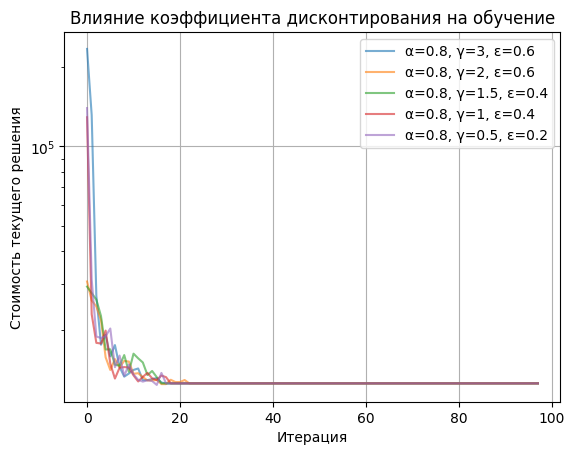

In [106]:
# Построение графика
plt.plot(cost_in_check_point_10[2:], label=f'\u03B1={0.8}, \u03B3={0.5}, \u03B5={0.2}', alpha=0.6)
plt.legend()
plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Стоимость текущего решения')
plt.title('Влияние коэффициента дисконтирования на обучение')
plt.grid(True)
plt.show()

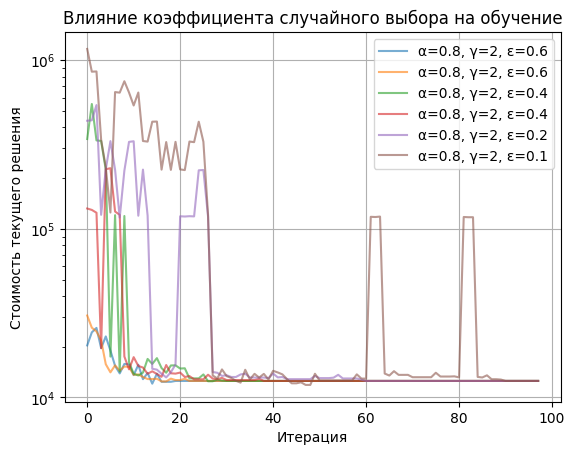

In [88]:
# Построение графика
plt.plot(cost_in_check_point_10[2:], label=f'\u03B1={0.8}, \u03B3={2}, \u03B5={0.1}', alpha=0.6)
plt.legend()
plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Стоимость текущего решения')
plt.title('Влияние коэффициента случайного выбора на обучение')
plt.grid(True)
plt.show()

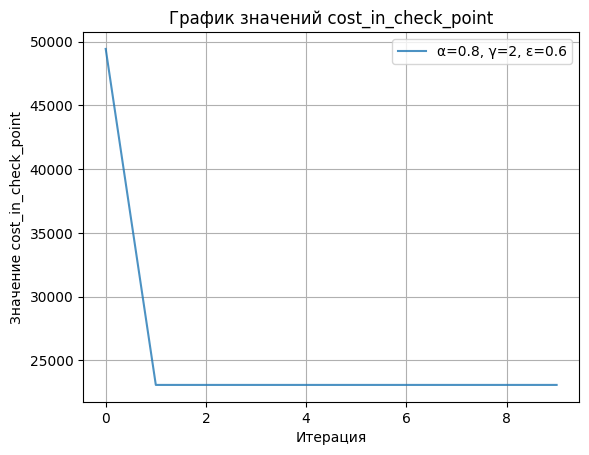

In [110]:
# Построение графика
plt.plot(cost_in_check_point[:], label=f'\u03B1={alpha}, \u03B3={rl_gamma}, \u03B5={epsilon}', alpha=0.8)
plt.legend()
#plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Значение cost_in_check_point')
plt.title('График значений cost_in_check_point')
plt.grid(True)
plt.show()

In [91]:
objvalue(problems[2], gamma, delta)

12521.69494508654

In [42]:
objvalue(problems[2], gamma, delta)

23585.544251127845

In [12]:
np.sum(gamma, axis=2)

array([[0., 2., 2., 0., 2.],
       [0., 0., 2., 2., 4.],
       [2., 0., 0., 2., 0.],
       [0., 2., 0., 2., 0.],
       [1., 0., 2., 2., 3.],
       [1., 1., 0., 0., 2.],
       [1., 1., 0., 1., 1.],
       [1., 0., 2., 1., 1.],
       [0., 0., 2., 0., 0.],
       [0., 0., 1., 1., 0.]])

In [105]:
gamma

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [90]:
gamma.shape

(10, 5, 10)

In [86]:
objvalue(problems[0], gamma, delta)

AssertionError: You cannot perform one operation in two cities at once. Gamma needs to be fixed.

In [9]:
np.sum(gamma, axis=2)

array([[0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 2.],
       [1., 0., 0., 1., 0.],
       [0., 2., 0., 2., 0.],
       [2., 0., 2., 1., 2.],
       [2., 2., 0., 0., 2.],
       [2., 2., 0., 2., 2.],
       [2., 0., 2., 2., 2.],
       [0., 0., 2., 0., 0.],
       [0., 0., 1., 2., 0.]])

In [26]:
problems[0]

{'name': '5,10,10-1',
 'n_operations': 5,
 'n_suboperations': 10,
 'n_cities': 10,
 'n_services': 1,
 'operations': array([[0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.]]),
 'dist': array([[   0.        , 1633.84292745,  611.70303957,   89.72076681,
         1130.56529382, 1238.97277599, 1035.89517346,  239.2701444 ,
          914.64484897, 2259.96549867],
        [1633.84292745,    0.        , 1739.44141395, 1718.00094704,
         2678.55942216, 1943.99364696, 2397.00976507, 1770.31697565,
         2532.42813768, 1388.23036974],
        [ 611.70303957, 1739.44141395,    0.        ,  649.74271027,
         1528.5603067 ,  632.84022906,  657.60732186,  427.72679529,
          980.23737024, 1942.79172047],
        [  89.72076681, 1718.00094704,  6